[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KMISchool2022/histFit/blob/main/histFit.ipynb)

In [ ]:
!pip install iminuit

In [1]:
# Example of maximum-likelihood fit with iminuit version 2.x
# pdf is a mixture of Gaussian (signal) and exponential (background),
# truncated in [xMin,xMax].
# G. Cowan / RHUL Physics / December 2022

import numpy as np
import scipy.stats as stats
from scipy.stats import truncexpon
from scipy.stats import truncnorm
from scipy.stats import chi2
import iminuit
from iminuit import Minuit
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14
print(f"iminuit version: {iminuit.__version__}")      #  should be v 2.x

iminuit version: 2.16.0


In [2]:
# Select fit type, define pdf
fitType = 'M'        # choose least squares (LS) or multinomial ML (M)
np.random.seed(seed=1234567)        # fix random seed
theta = 0.2                         # fraction of signal
mu = 10.                            # mean of Gaussian
sigma = 2.                          # std. dev. of Gaussian
xi = 5.                             # mean of exponential
xMin = 0.
xMax = 20.

def f(x, par):                      # fit function
    theta   = par[0]
    mu      = par[1]
    sigma   = par[2]
    xi      = par[3]
    fs = stats.truncnorm.pdf(x, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    fb = stats.truncexpon.pdf(x, b=(xMax-xMin)/xi, loc=xMin, scale=xi)
    return theta*fs + (1-theta)*fb

class ChiSquared:                   # function to be minimized

    def __init__(self, xHist, bin_edges, fitType):
        self.setData(xHist, bin_edges)
        self.fitType = fitType
        
    def setData(self, xHist, bin_edges):
        numVal = np.sum(xHist)
        numBins = len(xHist)
        binSize = bin_edges[1] - bin_edges[0]
        self.data = xHist, bin_edges, numVal, numBins, binSize

    def chi2LS(self, par):           # least squares
        xHist, bin_edges, numVal, numBins, binSize = self.data
        xMid = bin_edges[:numBins] + 0.5*binSize
        binProb = f(xMid, par)*binSize
        nu = numVal*binProb
        sigma = np.sqrt(nu)
        z = (xHist - nu)/sigma
        return np.sum(z**2)
        
    def chi2M(self, par):            # multinomial maximum likelihood
        xHist, bin_edges, numVal, numBins, binSize = self.data
        xMid = bin_edges[:numBins] + 0.5*binSize
        binProb = f(xMid, par)*binSize
        nu = numVal*binProb
        lnL = 0.
        for i in range(len(xHist)):
            if xHist[i] > 0.:
                lnL += xHist[i]*np.log(nu[i]/xHist[i])
        return -2.*lnL

    def __call__(self, par):
        if self.fitType == 'LS':
            return self.chi2LS(par)
        elif self.fitType == 'M':
            return self.chi2M(par)
        else:
            print("fitType not defined")
            return -1

In [3]:
# Generate data
numVal = 200
xData = np.empty([numVal])
for i in range (numVal):
    r = np.random.uniform();
    if r < theta:
        xData[i] = stats.truncnorm.rvs(a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    else:
        xData[i] = stats.truncexpon.rvs(b=(xMax-xMin)/xi, loc=xMin, scale=xi)

# Put data values into a histogram
numBins=40
xHist, bin_edges = np.histogram(xData, bins=numBins, range=(xMin, xMax))
binSize = bin_edges[1] - bin_edges[0]

In [4]:
# Initialize Minuit and set up fit:
parin   = np.array([theta, mu, sigma, xi])      # initial values (here = true)
parname = ['theta', 'mu', 'sigma', 'xi']
parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma$', r'$\xi$']
parstep = np.array([0.1, 1., 1., 1.])           # initial setp sizes
parfix  = [False, True, True, False]            # change to fix/free param.
parlim  = [(0.,1), (None, None), (0., None), (0., None)]
chisq = ChiSquared(xHist, bin_edges, fitType)
m = Minuit(chisq, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 1.0                      # errors from chi2 = chi2min + 1

In [5]:
# do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
parhat = m.values                                 # max-likelihood estimates
sigma_parhat = m.errors                           # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.

In [7]:
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(parhat[i]), " +/- ", "{:.6f}".format(sigma_parhat[i]))
         
print()
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not m.fixed[i]:
        for j in range(m.npar):
            if not m.fixed[j]:
                print(i, j, "{:.6f}".format(cov[i,j]), "{:.6f}".format(rho[i,j]))

# Retrieve minimized chi-squared, etc.
ndof = numBins - m.nfit - 1           # for fixed numVal
chi2min = chisq(parhat)
print ("chi2min = ", chi2min, ",     ndof = ", ndof)
pval = chi2.sf(chi2min, ndof)
print ("pval = ", pval)

par index, name, estimate, standard deviation:
   0 theta       =  0.201533  +/-  0.052956
   3 xi          =  5.148508  +/-  0.651156

free par indices, covariance, correlation coeff.:
0 0 0.002821 1.000000
0 3 -0.018494 -0.534693
3 0 -0.018494 -0.534693
3 3 0.424135 1.000000
chi2min =  35.26955011049647 ,     ndof =  37
pval =  0.5503255503742259


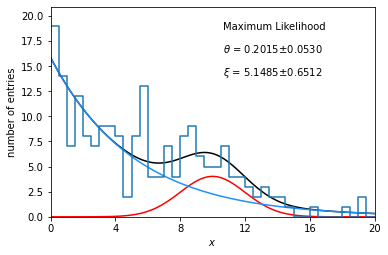

In [8]:
# Plot fit
fig, ax = plt.subplots(1,1)
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.15)
yMin = 0.
yMax = np.max(xHist)*1.1
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
plt.xticks(np.arange(xMin, xMax+1, 4.0))
xCurve = np.linspace(xMin, xMax, 100)
yCurve = f(xCurve, parhat)*numVal*binSize
sig_parhat = np.copy(parhat)
sig_parhat[0] = 1.
bkg_parhat = np.copy(parhat)
bkg_parhat[0] = 0.
sigCurve = f(xCurve, sig_parhat)*numVal*binSize*parhat[0]
bkgCurve =f(xCurve, bkg_parhat)*numVal*binSize*(1.-parhat[0])
plt.plot(xCurve, yCurve, color='black')
plt.plot(xCurve, sigCurve, color='red')
plt.plot(xCurve, bkgCurve, color='dodgerblue')

# Plot data histogram
binLo, binHi = bin_edges[:-1], bin_edges[1:]
xPlot = np.array([binLo, binHi]).T.flatten()
yPlot = np.array([xHist, xHist]).T.flatten()
plt.plot(xPlot, yPlot)
plt.xlabel(r"$x$")
plt.ylabel(r"number of entries")
y_fitval = 0.8
delta_y_fitval = 0.08
if fitType == 'LS':
    plt.figtext(0.55, y_fitval, r"Least Squares")
elif fitType == 'M':
    plt.figtext(0.55, y_fitval, r"Maximum Likelihood")
for i in range(len(parin)):
    if not parfix[i]:
        y_fitval -= delta_y_fitval
        plt.figtext(0.55, y_fitval, parname_latex[i] + ' = ' + f'{parhat[i]:.4f}' + r'$\pm$' + f'{sigma_parhat[i]:.4f}')
plt.show()
#plt.savefig("histFit.pdf", format='pdf')